In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import cv2
import dlib
import numpy as np
from imutils.face_utils import FaceAligner

In [2]:
# opencv dnn face detector
opencv_face_detector_path = {
    "proto": "./models/face_detect/deploy.prototxt.txt",
    "model": "./models/face_detect/res10_300x300_ssd_iter_140000.caffemodel"
}

face_detector = cv2.dnn.readNetFromCaffe(opencv_face_detector_path["proto"], 
                                         opencv_face_detector_path["model"])

In [6]:
# dlib face landmark detector
predictor = dlib.shape_predictor('./models/face_landmark/shape_predictor_68_face_landmarks.dat')

# face aligner
face_aligner = FaceAligner(predictor, desiredFaceWidth=256)

In [8]:
# save cropped aligned training faces
names = []
faces = []
train_dir = './images/train'

for person in os.listdir(train_dir):
    print('loading images of', person)
    for img_name in os.listdir(os.path.join(train_dir, person)):
        
        img = cv2.imread(os.path.join(train_dir, person, img_name))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # detect faces
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104, 177, 123))
        face_detector.setInput(blob)
        detections = face_detector.forward()
        
        # choose the most confident face
        if detections[0,0,0,2] < 0.8:
            print('No detected face:', img_name)
            continue
        box = detections[0, 0, 0, 3:7] * [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]
        box = box.astype('int')
        rect = dlib.rectangle(box[0], box[1], box[2], box[3])
        
        # face alignment
        aligned_face = face_aligner.align(img, img_gray, rect)
        
        names.append(person)
        faces.append(aligned_face)        
        
print('Done')        

loading images of kiki
loading images of tsungchan
loading images of real
loading images of ricebug
loading images of kaze
loading images of tsungyu
loading images of chiao


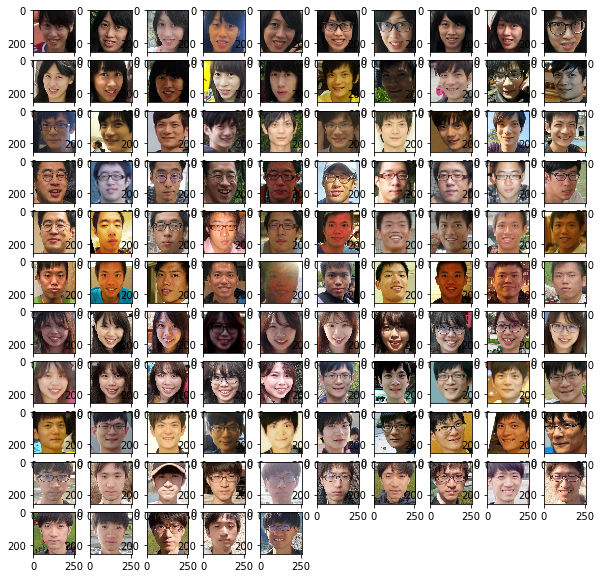

In [9]:
# plot all training faces

cols = 10
rows = len(faces) // cols + 1
plt.figure(figsize=(10, 10))
for i in range(len(faces)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(cv2.cvtColor(faces[i], cv2.COLOR_BGR2RGB))

In [10]:
# compute face embeddings (vgg face descriptor is a 4096d vector)

vgg_face = cv2.dnn.readNetFromCaffe('./models/vgg_face/VGG_FACE_deploy.prototxt', './models/vgg_face/VGG_FACE.caffemodel')
faceBlob = cv2.dnn.blobFromImages(faces, 1.0, (224, 224), (129.1863, 104.7624, 93.5940), swapRB=True, crop=False)    
vgg_face.setInput(faceBlob)
feat = vgg_face.forward('fc7')

# compute std for normalization
std = np.std(feat)
feat /= std
print('std for training data =', std)

std for training data = 9.411078


In [11]:
# save descriptors to csv file
import csv

with open('./output/train_vgg_face.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i, person in enumerate(names):
        csv_writer.writerow([person] + feat[i, :].tolist())